# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [68]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import time
import seaborn as sn
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [69]:
# Define transforms
## YOUR CODE HERE ##
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
pre_trained_model_normalization = transforms.Normalize(mean=mean, std=std)
train_transforms = transforms.Compose([transforms.RandomRotation(32),
                                       transforms.RandomResizedCrop(32),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       pre_trained_model_normalization])

test_transforms = transforms.Compose([
                                      transforms.Resize(32),
                                      transforms.CenterCrop(32),
                                      transforms.ToTensor(),
                                      pre_trained_model_normalization
                                      ])

# Create training set and define training dataloader
## YOUR CODE HERE ##
trainset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
testset = torchvision.datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

Class: bird, Shape: torch.Size([3, 32, 32])
Class: truck, Shape: torch.Size([3, 32, 32])
Class: dog, Shape: torch.Size([3, 32, 32])
Class: deer, Shape: torch.Size([3, 32, 32])


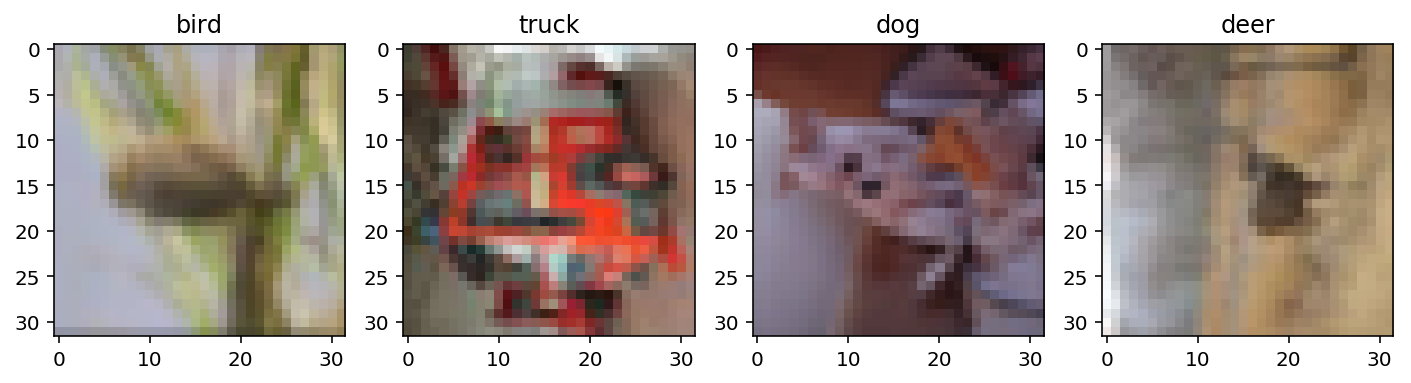

In [79]:
def show4(dataloader, label_mapping):
    dataiter = iter(dataloader)
    fig, ax = plt.subplots(figsize=(12, 10), ncols=4)

    batch = next(dataiter)
    labels = batch[1][0:4]
    images = batch[0][0:4]
    for i in range(4):
        title = label_mapping[labels[i].item()]
        print(f'Class: {title}, Shape: {images[i].shape}')
    
        image = images[i].numpy().T
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax[i].set_title(title)
        ax[i].imshow(image)

show4(testloader, classes)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [80]:
def build_network(architecture, out_features, hidden_layers, label_mapping, log_model=False):

  model = getattr(torchvision.models, architecture)(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False

  # Find the number of in features the classifier expects
  try:
      iter(model.classifier)
  except TypeError:
      in_features = model.classifier.in_features
  else:
      in_features = model.classifier[0].in_features

  hidden = [in_features] + hidden_layers

  layers = []
  for i, (x, y) in enumerate(zip(hidden[:-1], hidden[1:])):
    layers.append((f'fc{i}', nn.Linear(x, y)))
    layers.append((f'relu{i}', nn.ReLU()))
    layers.append((f'dropout{i}', nn.Dropout(p=0.2)))
  layers.append(('fc_final', nn.Linear(hidden_layers[-1], out_features)))
  layers.append(('log_output', nn.LogSoftmax(dim=1)))

  classifier = nn.Sequential(OrderedDict(layers))
  if log_model:
    print('Classifier:', classifier)

  classifier.out_features = out_features
  classifier.hidden_layers = hidden_layers
  classifier.label_mapping = label_mapping
  model.architecture = architecture
  
  model.classifier = classifier
  return model

label_mapping = {v: k for k, v in trainset.class_to_idx.items()}
model = build_network('vgg16', 10, [1000, 256, 64, 32], label_mapping, log_model=True)

Classifier: Sequential(
  (fc0): Linear(in_features=25088, out_features=1000, bias=True)
  (relu0): ReLU()
  (dropout0): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1000, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc_final): Linear(in_features=32, out_features=10, bias=True)
  (log_output): LogSoftmax()
)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [82]:
def save(model, filepath):
  checkpoint = {
    'out_features': model.classifier.out_features,
    'hidden_layers': model.classifier.hidden_layers,
    'architecture': model.architecture,
    'state_dict': model.state_dict(),
    'label_mapping': model.classifier.label_mapping,
  }
  torch.save(checkpoint, filepath)

def load(filepath):
  checkpoint = torch.load(filepath)
  model = build_network(checkpoint['architecture'],
                        checkpoint['out_features'],
                        checkpoint['hidden_layers'],
                        checkpoint['label_mapping'])
  model.load_state_dict(checkpoint['state_dict'])

  return model


In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [83]:
def train(model, criterion, optimizer, trainloader, testloader, epochs=1, logging_rate=1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f'Training on device: {device}')

    start_time = time.time()
    train_losses, eval_losses = [], []
    train_accuracies, eval_accuracies = [], []
    best_eval_accuracy = 0

    for e in range(epochs):
        train_loss = 0
        train_accuracy = 0
        eval_loss = 0
        eval_accuracy = 0

        for images, labels in trainloader: 
            model.train()
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            with torch.no_grad():
                model.eval()
                ps = torch.exp(model.forward(images))
                top_p, top_class = ps.topk(1, dim=1)
                train_accuracy += torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item()
            
        else:
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                with torch.no_grad():
                    model.eval()
                    log_ps = model.forward(images)
                    ps = torch.exp(log_ps)
                    top_p, top_class = ps.topk(1, dim=1)
                    eval_accuracy += torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item()
                    eval_loss += criterion(log_ps, labels).item()
        
        train_loss /= len(trainloader)
        train_accuracy /= len(trainloader)
        eval_loss /= len(testloader)
        eval_accuracy /= len(testloader)

        if eval_accuracy > best_eval_accuracy:
            best_eval_accuracy = eval_accuracy
            save(model, 'checkpoint.pth')

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        if logging_rate != 0 and (e+1) % logging_rate == 0:
            interval_time = time.time()  
            print(f'--- Epoch {e + 1} --- Time elapsed: {int(interval_time - start_time)} seconds')
            print(f'train_accuracy: {round(train_accuracy*100, 2)}%')
            print(f'eval_accuracy:  {round(eval_accuracy*100, 2)}%')
            print(f'train_loss:     {round(train_loss, 4)}')
            print(f'eval_loss:      {round(eval_loss, 4)}')

    print(f'Best model with evaluation accuracy of {round(best_eval_accuracy*100, 2)}% saved to checkpoint.pth and returned')
    model = load('checkpoint.pth')
 
    return model, (train_accuracies, eval_accuracies, train_losses, eval_losses)

model, stats = train(model, criterion, optimizer, trainloader, testloader, epochs=30, logging_rate=6)

Training on device: cuda:0


KeyboardInterrupt: 

Plot the training loss (and validation loss/accuracy, if recorded).

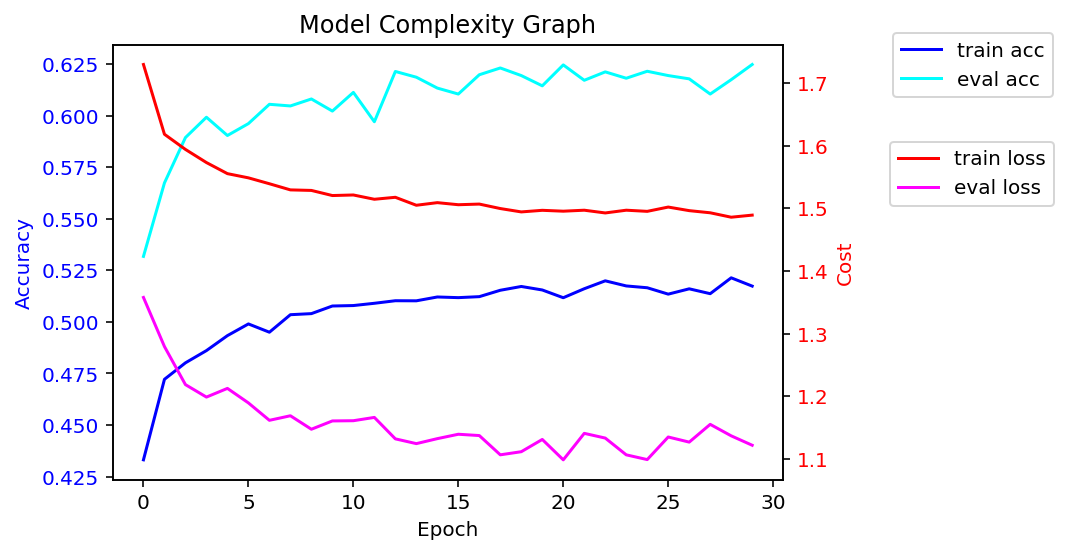

In [ ]:
def modelComplexityGraph(train_accuracies, eval_accuracies, train_losses, eval_losses):
  fig, ax1 = plt.subplots()
  epochs = len(train_accuracies)
  ax1.set_title('Model Complexity Graph')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy', color="blue")
  ax1.tick_params(axis='y', labelcolor='blue')
  ax1.plot(range(epochs), train_accuracies, color='blue', label='train acc')
  ax1.plot(range(epochs), eval_accuracies, color='cyan', label='eval acc')
  ax2 = ax1.twinx()
  ax2.set_ylabel('Cost', color="red")
  ax2.tick_params(axis='y', labelcolor='red')
  ax2.plot(range(epochs), train_losses, color='red', label='train loss')
  ax2.plot(range(epochs), eval_losses, color='magenta', label='eval loss')

  ax1.legend(bbox_to_anchor=(1.15, 1.05))
  ax2.legend(bbox_to_anchor=(1.42, 0.8))

modelComplexityGraph(*stats)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

Evaluation Loss:     1.1212
Evaluation Accuracy: 62.54%
Confusion Matrix:


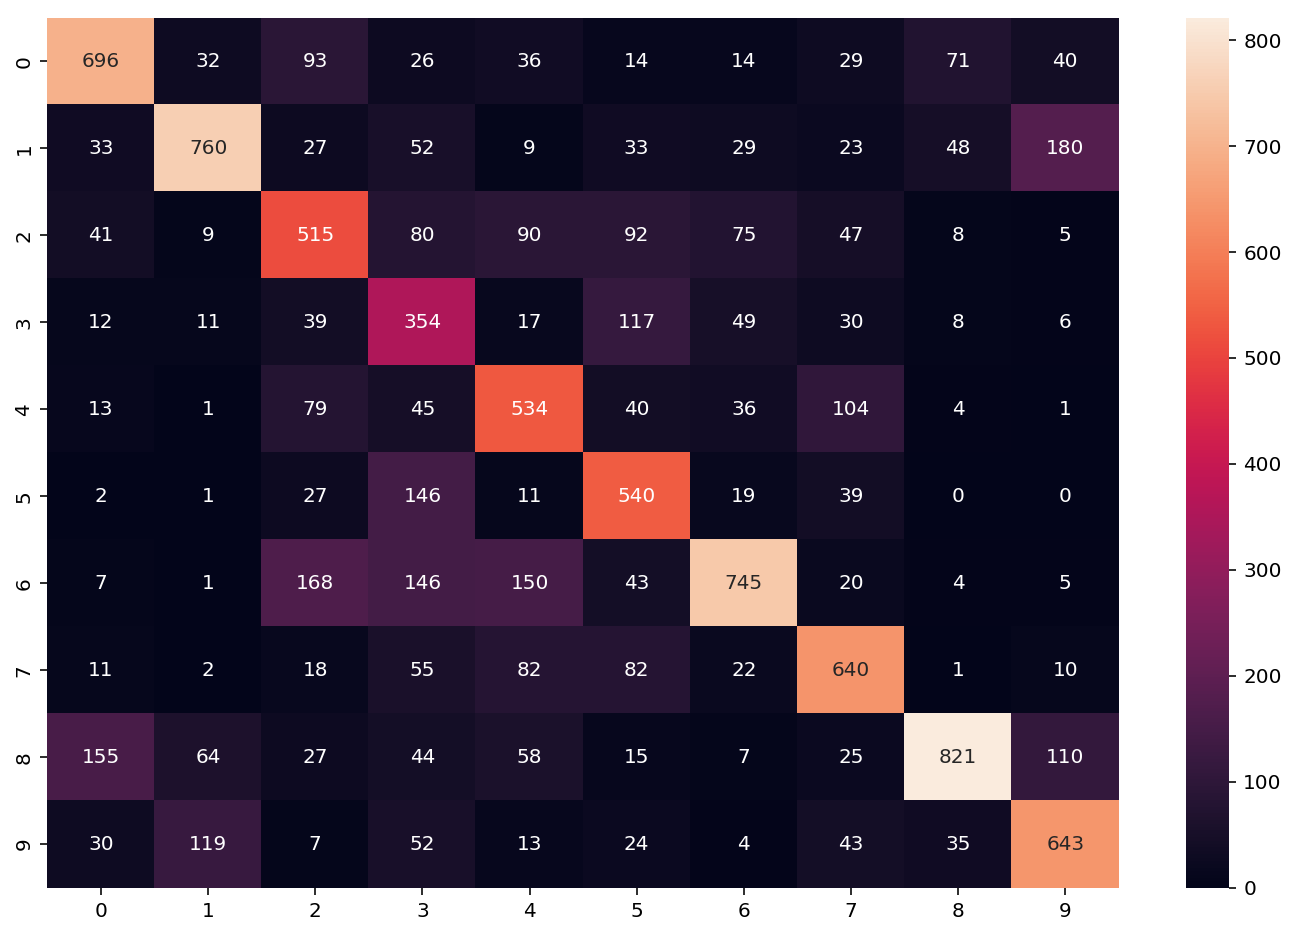

In [ ]:
def validate(model, testloader):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)

  eval_accuracy = 0
  eval_loss = 0
  num_features = model.classifier.out_features
  confusion_matrix = np.zeros((num_features, num_features))

  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      model.eval()
      log_ps = model.forward(images)
      ps = torch.exp(log_ps)
      top_p, top_class = ps.topk(1, dim=1)
      eval_accuracy += torch.mean((top_class == labels.reshape(*top_class.shape)).type(torch.FloatTensor)).item()
      eval_loss += criterion(log_ps, labels).item()
      for prediction, target in zip(top_class, labels):
        confusion_matrix[prediction[0]][target] += 1

  eval_loss /= len(testloader)
  eval_accuracy /= len(testloader)
  
  print(f'Evaluation Loss:     {round(eval_loss, 4)}' )
  print(f'Evaluation Accuracy: {round(eval_accuracy * 100, 2)}%')
  print('Confusion Matrix:')
  cm = pd.DataFrame(confusion_matrix, range(num_features), range(num_features))
  fig, ax = plt.subplots(figsize=(12,8))
  sn.heatmap(cm, annot=True, fmt='g', ax=ax)


validate(model, testloader)

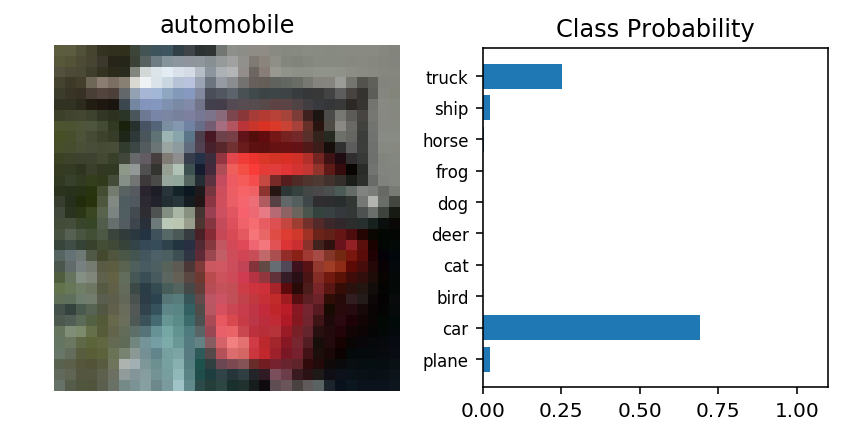

In [ ]:
def classify(model, image, label_idx):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model.to(device)
  with torch.no_grad():
    model.eval()
    img_tensor = image.reshape(1,3,32,32).to(device)
    ps = torch.exp(model.forward(img_tensor))
    ps = ps.data.cpu().numpy().squeeze()
    
    image = image.numpy().T
    image = std * image + mean
    image = np.clip(image, 0, 1)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(model.classifier.label_mapping[label_idx])
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    
image, label = next(iter(testloader))
classify(model, image[0], label[0].item())

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.


The model I made in-house is based off of Very Deep Convolutional Network architecture (vgg) for feature detection and a classifier made of 4 fully connected layers using ReLU activation.

I was able to achieve a 62.5% accuracy with this architecture compared to Detectocorp’s algorithm which has a 70% accuracy.

More tweaking of hyper-parameters such as base architecture for feature detection or composition of the hidden layers in the classifier may provide better performance, but for now I recommend that the company purchase Detectocorp’s algorithm.




